In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from microtc.textmodel import TextModel
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import  MultinomialNB
from sklearn.metrics import f1_score as f1, accuracy_score as acc 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
#import seaborn as sns

# Análisis semántico

Los vectores TF-IDF (términos frecuencia-vectores de frecuencia inversa del documento) que definimos en las secciones previas pueden ser utilizado para  determinar la importancia de las palabras en un fragmento de texto. Así como para calcular la importancia de cada palabra para el significado general de un fragmento de texto en una colección de documentos. 
Los valores de `importancia` de TF-IDF, también pueden ser calculados para secuencias cortas de palabras, es decir para $n$-gramas. Sin embargo los sistemas de NLP quiere ir más allá, se desea que una máquina sea capaz de comprender el `significado` de las palabras.

Una de las formas de hacerlo mediante el uso de `WordEmbeddings` que revisamos brevemente en la sección previa. Por otro lado una de la primeras formas que se utilizaron es el denominado análisis semántico latente (latent semantic analysis LSA). El uso de LSA, no solo permite representar el significado de las palabras como vectores, sino que permite que las usarlas para representar el significado de documentos completos, es decir el tópico del que trata el documento.

En esta sección, se presentarán los que denominaremos vectores semánticos o de tópico/tema. Se obtienen mediante el uso TF-IDF para calcular `índices` (scores) de tema que componen las dimensiones de los vectores de tópico. Lo anterior se basa en  el uso de la correlación de frecuencias de términos normalizados entre sí para agrupar palabras que consitutirán un tema.
Los vectores de tópicos de pueden utilizar para identificar documentos en función de su significado: búsqueda semántica. La mayoría de las veces, la búsqueda semántica es mejor que la búsqueda por palabras clave.  La búsqueda semántica es capaz de obtener resultados incluso cuando no se incluyen los términos exactos en la consulta.

Mediante el uso de los vectores semánticos para identificar las palabras y n-gramas que mejor representan el tópico de una sentencia, documento o colección de documentos (corpus). Con los vectores semánticos es posible comparar que tan `similares` en siginificado son dos elementos (sentencias, documentos).

## Frecuencia de términos  y pesado  de tópicos

Los vectores TF-IDF se generar mediante el conteo de las palabras en un documento, cada términos debe coincidir de fomar exacta para se contenado en la misma palabra (al menos así es cuando no se utiliza steming o lematización). Por lo tanto, los términos que tienen el mismo significado pero se escriben diferente  tendrán representaciones de vectoriales TF-IDF completamente diferentes. Es por ello que las búsquedas por palabra clave  pueden exihibir un desempeño pobre en representaciones basada en frecuencia de términos.

Meidante el uso de stemming/lematización, la palabras que comparten una misma raíz se agrupan en un sola término, con lo cual de obtienen colecciones de palabras con grafías similares y, a menudo, significados similares. La etiqueta de cada colección de palabras reemplaza en la lista de tokens a las palabras originales.

El enfoque previo solo garantiza que palabras escritas `de manera similar` se unifican en un solo token, pero no necesariamente garantiza que sus significados sean similares. Ni tampoco puede ser utilizada para emparejar la mayoría de los sinónimos. Esto ya que los sinónimos suelen diferir en más formas que las terminaciones de las palabras con las que se ocupan la lematización y stemming. Peor aún, la lematización/steaming a veces agrupan erróneamente antónimos, palabras con significado opuesto.

Derivado de lo anterior puede ocurrir que dos fragmentos de texto que hablan sobre lo mismo pero usan palabras diferentes no serán identificados como  `similares/cercanos` entre sí en un espacio vectorial TF-IDF lematizado. Además, es común,  que dos vectores TF-IDF que utilizan derivaciones que son `cercanos` entre si, no necesariamente tienen un significado similar. 


### Vectores de  tópicos(tema)

La estadística de palabras obtenidas por la representación TF-IDF, nos permite realizar operaciones matemáticas. Sin embargo, esas opercaiones nodicen mucho sobre como están relacionados los significados de las sentencias. También es posible calcular las representaciones TF-IDF palabra a palabra (vectores de co-ocurrencia o correlación de palabras) multiplicando la matriz TF-IDF por sí misma. Pero el `razonamiento vectorial` con estos vectores escasos y de alta dimensión no funciona bien. Las operaciones con estos vectores entre sí, no representan bien un concepto, palabra o tópico existente. 

En particular, nos  gustaría representar ese significado con un vector que al diferencia de un vector TF-IDF sea mas compacto (menor dimensión) y con más significado. A estos vectores de significado se les conoce `vectores palabra-tema`. Cuando estos vectores se crean por documento se les denomina `vectores de documento-tema`. Podemos referirnos a ellos indistitamento como `vectores de tema` o `vectores de tópico`. Estos vectores temáticos pueden ser compactos o de alta dimensión como desee.

Lo vectores de tópico a defierencia de TF-IDF perminten que la operaciones como sumas y diferencias representen una relación entre el significado de los elementos implicados. Es decir, podemos utilizar las distancias entre los vectores de tema para realizar  agrupación de documentos o búsqueda semántica. Mientras que TF-IDF, permite  agrupar y buscar usando palabras clave.

Partiendo de que se obtiene un vector palabra-tema para cada palabra en su léxico (vocabulario). Es posible calcular el vector de tema para cualquier documento nuevo simplemente sumando todos sus vectores de tema de palabra.

Sin embargo, obtener una representación numérica de la semántica (significado) de palabras y oraciones puede ser complicado. Esto es especialmente cierto para los idiomas `difusos` como el inglés o el español, que tiene varios dialectos y múltiples interpretaciones diferentes de las mismas palabras. Este concepto de palabras con múltiples significados se llama polisemia:

- **Polisemia**: es la existencia de palabras y frases con más de un significado.

A continuación enumeramos algunas formas en las que la polisemia puede afectar la semántica de una palabra o enunciado:

- Escritos:
    - *Homónimos*: palabras con la misma ortografía y pronunciación, pero con diferentes significados.
    - *Zeugma* : uso de dos significados de una palabra simultáneamente en la misma oración 

- Voz
    - *Homógrafos* : las palabras se escriben igual, pero con diferentes pronunciaciones y significados
    - *Homófonos*:  palabras con la misma pronunciación, pero diferentes deletreos y significados 

LSA puede lidiar con todos fenómenos polisemicos menccionados. Como ejemplo consider  las siguientes frases:
- `... él tuvo que cortar el tubo ...`
- `Evita evita la confrontación`
- `Grabe este grave asunto`

El problema al que no enfretamos es el reducir un vector TF-IDF de alta dimensión (decenas de miles de términos) a un vector unas pocas dimensiones (unas decenas). Para resolverto debemos encontrar esas dimensiones (palabras) que en conjunto representan un `tópico/tema` y sumar sus valores TF-IDF para crear un nuevo vector que representa la `relevancia` de ese tema en un documento dado. Una vez indentificados, podríamos ponderarlos por lo importantes que son para el tema, incluso podrían tener pesos negativos para las palabras que reducen la probabilidad de que el texto trate sobre ese tema. 

### Un ejemplo 
Supongamos que dado un vector TF-IDF para un documento se desea convertirlo en un vector de tema. Se debe pensar en cuánto contribuye cada palabra a tus temas. Supongamos que se tienen algunas sentencias sobre tres temas `animales`, `educacion` y `salud`. El tema `animales` daría mayor peso a palbaras **leon**, **gato**,etc;  
y probablemente ignoraría palabras como **historia**, **geografia**. El tema `educación` pordría darle poco peso los nombres de animales si tuvieran alguna relación con **ciencias naturales** por ejemplo. Vamos a `generar` un modelo utilizando solo nuestra intución.

In [2]:
topicos={}
# nuestra lista de terminos consiste de solo 6 palabras y generamos sus representaciones tfidf de forma aleatoria
tokens=['perro','gato','historia','examen','vacuna','gripe']
np.random.seed(33) # Para garantizar reproducibilidad
tfidf={token: np.random.rand(6) for  token in tokens } 

In [3]:
tfidf

{'perro': array([0.24851013, 0.44997542, 0.4109408 , 0.26029969, 0.87039569,
        0.18503993]),
 'gato': array([0.01966143, 0.95325203, 0.6804508 , 0.48658813, 0.96502682,
        0.39339874]),
 'historia': array([0.07955757, 0.35140742, 0.16363516, 0.98316682, 0.88062818,
        0.49406347]),
 'examen': array([0.40095924, 0.45129146, 0.72087685, 0.24776828, 0.62277995,
        0.14244882]),
 'vacuna': array([0.20117628, 0.08121773, 0.95347229, 0.05573827, 0.59953648,
        0.72299763]),
 'gripe': array([0.97028972, 0.82156946, 0.52755107, 0.33147673, 0.3539822 ,
        0.0790303 ])}

In [4]:
0.8*tfidf['perro']+0.8*tfidf['gato']-0.1*tfidf['historia']-0.1*tfidf['examen']

array([0.16648556, 1.04231207, 0.78466209, 0.47441674, 1.31799719,
       0.3990997 ])

In [5]:
# ahora suponemos los pesos de cada palabra en cada tópico
pesos_animales=[0.8,0.8,-0.1,-0.1,0.2,0.2] 
# suponemos un peso de 0.5 para perro y gato, 
# -0.1 para historia y examen y  0.2 para vacuna y gripe
pesos_educacion=[0.1,0.1,0.7,0.7,-0.1,-0.1] 
pesos_salud=[0,0,-0.2,-0.2,0.6,0.8] 
topicos['animales']=np.sum([peso*tfidf[token] for peso,token in zip(pesos_animales,tokens)], axis=1)
topicos['educacion']=np.sum([peso*tfidf[token] for peso,token in zip(pesos_educacion,tokens)], axis=1)
topicos['salud']=np.sum([peso*tfidf[token] for peso,token in zip(pesos_salud,tokens)], axis=1)

In [6]:
topicos

{'animales': array([ 1.94012933,  2.79870236, -0.29524586, -0.25861246,  0.52282774,
         0.61677989]),
 'educacion': array([ 0.24251617,  0.34983779,  2.06672104,  1.81028722, -0.26141387,
        -0.30838995]),
 'salud': array([ 0.        ,  0.        , -0.59049173, -0.51722492,  1.56848321,
         2.46711958])}

En este ejercicio los pesos de cada palabra los ponemos en función de la probabilidad que suponemos que cada palabra esté asociada con un tema en particular y sumamos los vectores resultantes. Cuando suponemos que una palabra no está relacionada con el tópico podemos suponer un peso de 0 o incluso un peso negativo si está aumenta la probabilidad que el documento no este relacionado con el tópico. El ejerciocio solo pretenden ilustrar como debería operar el algoritmo que aprenderá los vectores semánticos. 

La transformación al modelado de temas está dada por la matriz de proporciones (pesos) que conecta los temas con cada palabara en el vocabulario (en este cado 3x6). Cada vector TF-IDF de dimension del tamaño del vocabulario (para el ejemplo 6 x 1) debería multiplicarse por la matriz de tópicos  para obtener el vector de tema de 3 x 1.

En este ejemplo intuimos los los pesos, pero para poder implementar un algoritmo deberíamos preguntarnos ¿Cómo podrías optimizarlos pesos? ¿Qué podría utilizarse como medida objetiva de lo pesos? ¿Que efecto tiene el corpus utilizado? Otra persona podría decidir que los pesos asignado sean diferente en ese caso: ¿Qué podríamos hacer para llegar a un consenso sobre sus opiniones sobre estas seis palabras y tres temas?

Note que  la matriz obtenida nos dice como cada tópico es representado por el vocabulario

In [7]:
pd.DataFrame(topicos,index=tokens).transpose()

,perro,gato,historia,examen,vacuna,gripe
animales,1.940129,2.798702,-0.295246,-0.258612,0.522828,0.61678
educacion,0.242516,0.349838,2.066721,1.810287,-0.261414,-0.30839
salud,0.000000,0.000000,-0.590492,-0.517225,1.568483,2.46712


si transponemos la matriz podemos obtener los vectores para cada palabra en terminos de cada tópico

In [8]:
word_vector=pd.DataFrame(topicos,index=tokens)
word_vector

,animales,educacion,salud
perro,1.940129,0.242516,0.000000
gato,2.798702,0.349838,0.000000
historia,-0.295246,2.066721,-0.590492
examen,-0.258612,1.810287,-0.517225
vacuna,0.522828,-0.261414,1.568483
gripe,0.616780,-0.308390,2.467120


In [9]:
word_vector.values

array([[ 1.94012933,  0.24251617,  0.        ],
       [ 2.79870236,  0.34983779,  0.        ],
       [-0.29524586,  2.06672104, -0.59049173],
       [-0.25861246,  1.81028722, -0.51722492],
       [ 0.52282774, -0.26141387,  1.56848321],
       [ 0.61677989, -0.30838995,  2.46711958]])

Text(0.5, 0, 'salud')

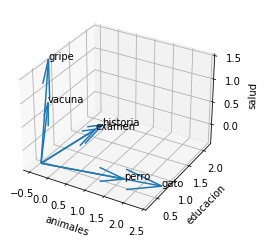

In [10]:
fig = plt.figure()
soa=[np.concatenate(([0,0,0],val)) for val in word_vector.values ]
ax = fig.gca(projection='3d')
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-0.6, 2.5])
ax.set_ylim([0.2, 2.2])
ax.set_zlim([-0.4, 1.5])
for pos,token in zip(word_vector.values,tokens):
    #print(pos[0],pos[1],pos[2],token)
    ax.text(pos[0],pos[1],pos[2],token)
ax.set_xlabel('animales')
ax.set_ylabel('educacion')
ax.set_zlabel('salud')

como nuestro ejemplo las palabra de los diferentes tópicos están bien separados. Estos seis vectores de temas, uno para cada palabra, representan los significados de sus seis palabras como vectores en tres dimensiones.

Si solo calculamos la frecuencia de las apariciones de estas seis palabras y las multiplica por sus pesos, obtendrá el vector de tema tri-dimensional para cualquier documento. Los vectores 3D nos permiten generar una visualización que puede resultar de ayuda para realizar un análisis exploratorio, además también pueden utilizarse para los problemas de clasificación de aprendizaje automático. Recuerde que:  un algoritmo de clasificación lineal divide el espacio vectorial con un plano (o hiperplano) para dividir el espacio en clases. Los documentos del corpus pueden usar muchas más palabras, pero un modelo de vector de tema en particular solo se verá influenciado por el uso del conjunto de palabras que definen el tema.

Un modelo basado en tópicos solo separa los documentos basado en el número de temas, por lo que que no se ve "afectado" por el incrementeo del vocabularioa. En ejmplo se comprimió una representación de 6 dimensiónes a una de 3 (una por cada tema).

El proceso que realizamos está principalmente basado en análisis semántico utilizando nuestra intuición y el sentido común para dividir los documentos en temas. Ahora tratemos de poner esa intuición en un algoritmo que nos permita determinar le número de temeas de forma automática. Si lo analizamos, cada una de las sumas ponderadas que utilizamos son solo un producto escalar (producto punto). Y tres productos punto  es solo una multiplicación de matrices o producto interno. Multiplica una matriz de pesos de $3 \times N$ con un vector TF-IDF, donde $N$ es el tamaño del vocabulario. Se obtine un nuevo vector de tema de 3 x 1 para el documento. Lo que hicimos fue transformar un vector de un espacio vectorial (TF-IDF) a otro espacio vectorial de menor dimensión (vectores de tópicos). Un para generación de tópicos debe crear una matriz de $N$ términos por $M$ tópicos, la cual utilizaremos para a partir de un vector de frecuencias de palabras de un documento obtener su vecror de tópico correspondiente en dimensión $M$.

### Pesado de tópicos

Deseamos que un algoritmo sea capaz de identificar qué palabras van juntas o qué significan. El lingüista británico J. R. Firth, estudió las formas en que se puede estimar lo que significa una palabra o morfema. 
En 1957 le dio una pista sobre cómo calcular los temas para las palabras "Puedes conocer una palabra por las que la acompañan" ¿Recuerda el contexto de los word-embeddings?

Entonces, como determinamos la compañia de una palabra. El enfoque más simple es calcular la matriz de co-ocurrencias como ya lo hicimos con la bolsa de palabras (BOW) y los vectores TF-IDF.  Podemos hacerlo mejor mediate el uso de LSA para analizar la matriz TF-IDF para agrupar palabras en temas. También funciona en vectores de bolsa de palabras, pero los vectores TF-IDF dan usalmente mejores resultados.

Además LSA también permite optimizar los tópicos y mantener la diversidad en las dimensiones; por lo que cuando se utiliza el modelo de tópicos en lugar del vocabulario originale, se mantiene gran parte del significado (semántica) de los documentos. El número de temas que se requieren para que un modele semántico capture el significado es mucho menor que la cantidad de palabras en el vocabulario de sus vectores TF-IDF. Por lo tanto, a menudo se hace referencia a LSA como una técnica de reducción de dimensiones (si conoce PCA, LSA es un PCA sobre representaciones de documentos). 

Dos algoritmos similares a LSA, con aplicaciones de PLN son: Linear discriminant analysis (LDA) y Latent Dirichlet allocation (LDiA). Mientras que LDA descompone un documento en un único tema. LDiA se parece más a LSA porque puede dividir documentos en tantos temas como desee. 


#### Clasificación utilizando LDA

LDA es uno de los modelos de clasificación y reducción de dimensiones más simples y rápidos que existen. A pesar de su simplicidad LDA muestra un desempeño sobresalinete en muchas aplicaciones, en ocasiones incluso competitiva con  algoritmos del estado del arte. Como LDA es un algoritmo supervisado, requiere las etiquetas/clases de documento. Ahora mostraremos una implementación simple que consiste de solo 3 pasos (tomadas de [1]).

1. Calcule la posición promedio (centroide) de todos los vectores TF-IDF dentro de la clase positiva.
2. Calcule la posición promedio (centroide) de todos los vectores TF-IDF que no están en la clase negativa.
3. Calcule la diferencia vectorial entre los centroides (el vector que los une).

Todo lo que se requiere para  “entrenar” un modelo LDA es encontrar el vector (línea) entre los dos centroides para una problema de clasificación binaria. Por ejemplo utilicemos los tweets de EmoVal para disitinguir si un texto particular es o no ofensivo. 

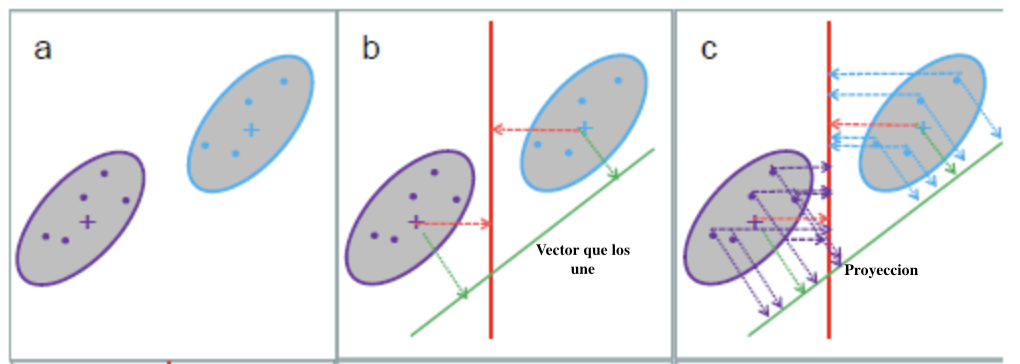

In [11]:
train_df=pd.read_csv('data/train_emo.tsv',sep='\t')
test_df=pd.read_csv('data/dev_emo.tsv',sep='\t') 

In [12]:
train_df

,id,event,tweet,offensive,emotion
0,a0c1a858-a9b8-4cb1-8a81-1602736ff5b8,GameOfThrones,La Gran Guerra de #JuegoDeTronos nos ha dejado...,NO,others
1,9b272817-a231-4f68-bdf4-3350d4919330,Venezuela,El golpe de Estado en #Venezuela está más lejo...,NO,others
2,4bd5b1e5-4b74-440a-82f4-c2567a241011,NotreDame,No tengo una foto en la catedral de #NotreDame...,NO,sadness
3,0bb9d7c9-d781-4684-890e-a94bfb50acc0,NotreDame,#NotreDame nunca llegue a visitar tan grandios...,NO,sadness
4,88749098-d539-4500-9209-0bbfae2b109c,GameOfThrones,A tomar por culo mi crush 😭😭😭😭😭#JuegoDeTronos,OFF,sadness
...,...,...,...,...,...
5718,c724c23b-2f6e-46f4-b740-0a7186349f60,Venezuela,"#Venezuela Querida, un dictador como Maduro so...",NO,others
5719,ee10fa89-f6ad-4f61-9bf7-d90604ce5b6b,NotreDame,#Notredame Impactantes imágenes que ha dejado ...,NO,sadness
5720,c0524970-cd8f-41a6-b9fa-ed052b23c297,Venezuela,¡ESCUCHA MADURO! Militares de #USA estarán ate...,NO,others
5721,f7b79584-d865-4e86-a83a-159792e98158,NotreDame,#NotreDame : 💔 💔 💔 Todo es efímero como el arc...,NO,others


In [13]:
# Generamos un modelo microtc y tranformamos los textos
mtc=TextModel()
datos=[{'text':tweet, 'klass':c} 
       for tweet,c in zip(train_df.tweet,train_df.offensive)]
mtc.fit(datos)
train=mtc.transform(train_df.tweet)
test=mtc.transform(test_df.tweet)

In [14]:
# Usamos un labelencorder
le=LabelEncoder()
le.fit(train_df.offensive)
y=le.transform(train_df.offensive)
yt=le.transform(test_df.offensive)

In [15]:
np.bincount(y)

array([5253,  470])

In [16]:
#Utilizamos un modelo naibe bayes
nb=MultinomialNB()
nb.fit(train,y)
print(f"test f1 score:{f1(yt,nb.predict(test))}, accuracy:{acc(yt,nb.predict(test))}")
print(f"train f1 score:{f1(y,nb.predict(train))}, accuracy:{acc(y,nb.predict(train))}")

test f1 score:0.0, accuracy:0.909952606635071
train f1 score:0.0, accuracy:0.9178752402586057


In [17]:
print(f"test f1 score:{f1(yt,[0 for p in yt])}, accuracy:{acc(yt,[0 for p in yt])}")

test f1 score:0.0, accuracy:0.909952606635071


In [18]:
# El tamaño del vocabulario
train.shape

(5723, 18489)

Tenemos  18489 palabras en su vocabulario.  En este caso en particular tenemos más del triple de palabras que tweets. Y si lo hacemos por clase la diferencia es peor. Por lo general, como pudo observar un clasificador Naive Bayes no funcionará bien cuando su vocabulario es mucho mayor que el número de ejemplos etiquetados en su conjunto de entrenamiento. En estás circunstancias, podemos echar mano de la técnicas de análisis semántico. Aún cuando `sklearn` ya cuenta con una implementación como en este caso, solo es necesario los centroides de cada una de las dos clases binaria (NO, OFF) implementaremos nuestra propia versión. 

In [19]:
class miLDA:
    def __init__(self,X,y):
        centroid_no = X[y==0].mean(axis=0) # calulamos el centroide para clase no ofensivo
        centroid_off = X[y==1].mean(axis=0) # calulamos el centroide para clase ofensivo
        self.distancia=centroid_off-centroid_no #Calulamos el vector que los une
    def predict(self, data):
        ofensividad=data.dot(self.distancia.transpose()) # calculamos el nivel de ofensa
        probabilidad= MinMaxScaler().fit_transform(ofensividad.reshape(-1,1)) #ajustamos entre 0,1 
        return probabilidad

El vector `ofensividad` es la distancia entre los centroides de los datos ofensivos y no ofensivos. Para deteminar el valor para cada vector TF-IDF en esa línea entre los centroides utilizaremos el producto escalar, es decir proyectamos cada vector TF-IDF  en la linea. Hacemos el producto de forma matricial, lo cual es más eficiente que utilizar un ciclo. Con la normalización hacemos que el valor de `ofensividad` sea una probabilidad.

In [20]:
lda=miLDA(train,y)
probas=lda.predict(test)

Hacemos la predicción como ofensivo todos los valores con una probabilidad mayor a 0.5, no ofensivo en caso contrarion

In [21]:
yp=[ p>0.5 and 1 or 0 for p in probas]
ypt=[p>0.5 and 1 or 0 for p in lda.predict(train)]
#Calculamos las métricas
print(f"test f1 score:{f1(yt,yp)}, accuracy:{acc(yt,yp)}")
print(f"train f1 score:{f1(y,ypt)}, accuracy:{acc(y,ypt)}")

test f1 score:0.14634146341463414, accuracy:0.9170616113744076
train f1 score:0.2430939226519337, accuracy:0.9281845186091211


Como puede observar aún cuando la mejora no es sorprendete, si es significativa para un enfoque tan simple como es LDA. Esto muestra la mejora  derivada de los enfoques de análisis semántico. A diferencia de Naive Bayes, el modelo semántico no se basa en palabras individuales. El análisis semántico reúne palabras con semántica similar (como ofensivas) y las usa todas simultaneamente. Los resultados previos se verían modificados mediante el ajuste del umbral de probabilidad. 

In [22]:
for u in [0.2,0.3,0.4]:
    yp=[ p>u and 1 or 0 for p in probas]
    ypt=[p>u and 1 or 0 for p in lda.predict(train)]
    print(f"umbral: {u}")
    print(f"train f1 score:{f1(y,ypt)}, accuracy:{acc(y,ypt)}")
    print(f"test f1 score:{f1(yt,yp)}, accuracy:{acc(yt,yp)}")
    print(f"============================")

umbral: 0.2
train f1 score:0.2715905786565862, accuracy:0.5622925039315044
test f1 score:0.26116838487972505, accuracy:0.490521327014218
umbral: 0.3
train f1 score:0.6295907660020986, accuracy:0.9383190634282719
test f1 score:0.47674418604651164, accuracy:0.8933649289099526
umbral: 0.4
train f1 score:0.4065040650406504, accuracy:0.9362222610518959
test f1 score:0.32258064516129026, accuracy:0.9253554502369669


### LDiA 

LDiA (Latent Dirichlet allocation) es otra técnica emparenteada con LSA que puede ser utilizada para generar vectores que capturan la semántica de una palabra o documento. LDiA utiliza un algoritmo estadístico no lineal para agrupar palabras. Como resultado, generalmente es más lento que los enfoques lineales como LSA. A menudo, esto hace que LDiA sea menos práctico para muchas aplicaciones del mundo real. No obstante, las estadísticas de los temas son más similares a la intuición humana. Por lo que, los tópicos obtenidos mediante LDiA a menudo serán más fáciles de interpretar. Además LDiA puede usarse para problemas un solo documento, en el cual ser obtendría un resumen del mismo. El documente genera un corpus, donde cada sentencia es un documento de la colección. Esa idea es la que implementa  `gensim` y otros paquetes que proporcionan un modulo para dentificar las oraciones  `centrales` de un documento. Las sentencias obtenidas se pueden unir para crear un resumen generado por una máquina. Para la mayoría de los problemas de clasificación o regresión, normalmente es mejor utilizar LSA.

##  Análisis semántico latente (LSA)

LSA se basa en una de las técnicas más antigua y más ampliamente utilizada para la reducción de dimensiones, la descomposición de valores singulares (Singular Value Descomposition SVD).  SVD se ha utilizado desde antes de que existiera el aprendizaje automático. La  técnina consiste en descomponer una matriz en tres matrices cuadradas, una de las cuales es una matriz diagonal.

Una matriz se puede invertir mediante el uso de SVD, la matriz se descompone en tres matrices cuadradas más simples, despues se transponen las matrices y finalmente se multiplican. Es facil imagenes, todas las aplicaciones de un algoritmo que proporciona una forma eficiente para invertir matrices grandes. SVD es ampliamente aplicado a problemas de ingeniería e incluso se utiliza en ciencia de datos para sistemas de recomendación basados.

### SVD y LSA

El uso de SVD, perminte dividir una matriz de documentos TF-IDF en tres matrices más simples. Mediante el uso de las matrices obtenidas se pueden recosntruir la matriz original al multiplicarlas. En terminos simples lo que se hace es factorizar un matriz en tres matrices mas simples. Además la tres matrices obtenidas mediante SVD revelan propiedades de la matriz TF-IDF original que pueden ayudar simplificarla. Por ejemplo, podemos truncar esas matrices (eliminar algunas filas y columnas) antes de volver a multiplicarlas, como resultado se ontendía un modelo de espacio vectorial de menores dimensiones.

El uso de las matrices truncadas no rescontruye exactamente la matriz orinignal, sino más bien es una aproximáción, la cual es un muchos caso puede resultar mejor que la representación original. Lo anterior debido a que la nueva representación contiene la `semántica latente` de los documentos. Debido a lo anterior es que SVD es frecuentemente utilizada en aplicaciones de compresión. La mejor respresentación en es parte debido a que al capturar la escencia se tiene una reducción del ruido presente en los datos. 

En el caso de PLN, el uso de LSA permite "descubir" la semántica, o el significado oculto de las palabras.  En este sentidos podemo decir que LSA es una técnica que permite encontrar la transformación `óptima` de un conjunto de vectores TF-IDF o BoW. Para muchos problemas de alta dimension la mejor transformación es alinear los ejes (dimensiones) en sus nuevos vectores con la mayor "extensión" es decir los que presentan una mayor varianza en la frecuencia de las palabras. Posteriormente se  pueden eliminar todas las dimensiones en el nuevo espacio vectorial que no contribuye significativamente. Al uso de SVD de esta manera se le conoce como descomposición de valores singulares truncado (Truncate SVD).

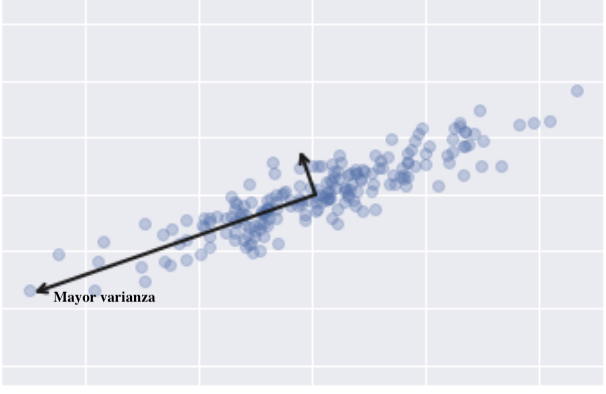

Cuando aplicamos LSA,  SVD se utiliza para encontrar las combinaciones de palabras que juntas, representan la mayor variación en los datos. Durante el proceso, los vectores TF-IDF puende ser rotados para que las nuevas dimensiones (vectores base) se alineen con las direcciones de varianza máxima. Los “vectores base” representan los ejes del nuevo espacio vectorial y son análogos a los vectores de tópicos. Cada una de las dimensiones resultantes representan una combinación de las frecuencias de palabras en lugar de la frecuencia de una palabra a la vez. En resumen,  las dimensiones resultates son combinaciones ponderadas de palabras que componen los tópicos que se utilizan a lo largo de su corpus.

Una máquina no es capaz de "entender" lo que significan las combinaciones de palabras, solo aprende que usualmente aparecer juntas. Cuando ve muchas palabras como "perro", "gato" y "iguana", las agrupa en un tema. No sabe que un nombre apropiado para ese tópico podría ser `mascotas`. Puede incluir muchas palabras como "veterinario" y "arena" en el mismo tema, o incluso palabras que significan lo opuesto entre sí. Si ocurren juntos muchos en los mismos documentos, LSA les dará puntajes altos para los temas similares. Sin embargo, la descripción o nombre del tema  depende de la interpretación humana. 

El darle un nombre un tópico no es necesario para poder aprovecharlo en diferentes tareas. De igual forma como no no analizamos los miles de dimensiones en los vectores BoW o TF-IDF, no  se tiene que comprender el significado todos sus temas para realizar  operaciones matemáticas con esta nueva transformacion. 

LSA  nos permite  identificar las dimensiones del  vector importantes para la semántica (significado) de los documentos. Por lo que podemos descartar aquellas dimensiones (tópicos) que tengan contribuyan poco a la variación entre documentos. Si cada documento tiene aproximadamente la misma proporcion de algún tema y este no ayuda a diferenciar los documentos, entonces podemos deshacernos de él. Y eso ayudará a generalizar la representación vectorial para que funcione mejor cuando la utilicemos con documentos que no son parte del corpus de entrenamiento.

Esta generalización y compresión que realiza LSA logra lo que intentamos con el uso de las las palabras vacías o derivaciones. Pero la reducción de la dimensión LSA es mejor, porque es óptima. Retiene la mayor cantidad de información posible y no descarta ninguna palabra, solo descarta dimensiones (tópicos poco relevantes). LSA comprime el significado en menos dimensiones. Solo tenemos que retener las dimensiones de alta varianza, los temas principales de los que habla su corpus en una variedad de formas (con alta varianza). Y cada una de estas dimensiones se convierte en los tópicos del corpus, con una combinación ponderada de todas las palabras capturadas en cada tema.

### Descomposición en valores singulares

Como ya mencionamos LSA está basado en el uso de descomposición en valores singulares. Analizaremos el método mediante un ejemplo. Utilizaremos el poema de **Federico García Lorca** titulado *Cogida y Muerte*, cada consideraremos como un documento cada línea del poema; colo que obtenemos un total de 30 documentos y un vocabulario de 102 palabras. Note que hemos removido los acentos y signos de puntuación. 

In [23]:
## Poema Cogida y Muerte de Federico García Lorca
poema="""a las cinco de la tarde
eran las cinco en punto de la tarde
un niño trajo la blanca sabana a las cinco de la tarde
una espuerta de cal ya prevenida a las cinco de la tarde
lo demas era muerte y solo muerte a las cinco de la tarde
el viento se llevo los algodones a las cinco de la tarde
y el oxido sembro cristal y niquel a las cinco de la tarde
ya luchan la paloma y el leopardo a las cinco de la tarde
y un muslo con un asta desolada a las cinco de la tarde
comenzaron los sones del bordon a las cinco de la tarde
las campanas de arsenico y el humo a las cinco de la tarde
en las esquinas grupos de silencio a las cinco de la tarde
y el toro solo corazon arriba a las cinco de la tarde
cuando el sudor de nieve fue llegando a las cinco de la tarde
cuando la plaza se cubrio de yodo a las cinco de la tarde 
la muerte puso huevos en la herida a las cinco de la tarde
a las cinco en punto de la tarde
un ataud con ruedas es la cama a las cinco de la tarde
huesos y flautas suenan en su oido a las cinco de la tarde
el toro ya mugia por su frente a las cinco de la tarde
el cuarto se irisaba de agonia a las cinco de la tarde
a lo lejos ya viene la gangrena a las cinco de la tarde
trompa de lirio por las verdes ingles a las cinco de la tarde
las heridas quemaban como soles a las cinco de la tarde
y el gentio rompia las ventanas a las cinco de la tarde
a las cinco de la tarde
ay que terribles cinco de la tarde
eran las cinco en todos los relojes
eran las cinco en sombra de la tarde
"""
#cada linea es un documento
corpus_poema=poema.split('\n')

In [24]:
# Snipet de código para obtener el vocabulario
vocabulario={}
for i,doc in enumerate(corpus_poema):
    for word in doc.split():
        vocabulario[word]=vocabulario.get(word,0)+1
voc=list(vocabulario.items())
voc.sort()
terminos=[t for t,c in voc]

In [25]:
# Obtenemos la bolsa de palabras 
BoW=[]
for i,doc in enumerate(corpus_poema):
    tokens={}
    for word in doc.split():
        tokens[word]=1
    BoW.append(tokens)
poema_BoW=pd.DataFrame(BoW).fillna(0).astype(int)

In [26]:
poema_BoW.head() #Dimension 101

,a,las,cinco,de,la,tarde,eran,en,punto,un,...,soles,gentio,rompia,ventanas,ay,que,terribles,todos,relojes,sombra
0,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
wpv=poema_BoW.transpose() 

In [28]:
wpv.head() # La representación de cada palabra en terminos de los 30 documentos en la colección

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
a,1,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
las,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,0
cinco,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
de,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
la,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0


#### El método SVD
SVD permite  descomponer cualquier matriz en tres matrices que pueden utizarse para recoustruir la matriz original. Lo anterior es simalara descomponer un número en sus factores primos. Solo que en este caso no se buscan valores escalares, si no más bien 3 matrices de números reales. 
Las matrices obtenidas mediante SVD tienen algunas propiedades matemáticas útiles que  nos ayudan a realizar unp proceso de reducción dla reducción, así como a identificar los tópicos presentes en la colección de doucmentos. 

Al aplicarse SVD sobre una matriz de BoW o TF-IDF se encuentran simultáneamente la correlación del uso de términos entre documentos, así como la correlación que existe entre los documentos del corpus. Además también se determinan las combinaciones lineales de los términos que presentan la mayor variaza en el corpus. Las combinaciones lineales represeantan lo temas presentes en la colección. Los matrices (factores) obtenidos por SVD puden ser utilizados para realizar una transformación que resulta en uan reducción que dimensión a la vez que se conserva la información semántica de los documentos SVD agrupa los términos que tienen una alta correlación entre sí (identificado cuales ocurren mucho juntos en los mismos documentos) y también varían mucho "juntos" en el corpus.  Los vectores obtenido, son vectores de tópico, el cual puede entenderse como un resumen o generalización de lo que trata el documento.

Ahora pongamos SVD en notación matemática:

$$W_{M \times N}=U_{M \times l} S_{l \times l} V_{l \times N}^T,$$

donde $N$ es el tamaño del vocabulario, $M$ el número de documentos en el corpus y $l$ es el número de tópicos presentes en el corpus (es decir $l=M$), que sería equivalente al número de palabras. Lo que haremos será utilizar las matrices $U, S$ y $V$ para identificar cuales combinaciones de esos tópicos son las más `relevantes`.


##### La matrix U

Esta matriz es la más para el proceso de análisis semántico. La matriz $U$ contiena la relación `tópico-término` es decir el contexto de las palabras (quienes son su compañia). U es conociada como la matriz de  `vectores singulares izquierdos` porque contiene vectores de fila que deben multiplicarse por la izquierda; $U$ captura la  correlación cruzada entre palabras y temas en el mismo documento. Esta matriz podemos tuncarla para reducir el número de columnas. Ahora veamos el ejemplo para el poema de Gracía Lorca.

In [29]:
 U, S, Vt = np.linalg.svd(wpv.values)

In [30]:
U.shape #es una matriz cuadrada 

(101, 101)

In [31]:
pd.DataFrame(U, index=wpv.index).round(2)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
a,-0.36,-0.17,-0.17,-0.04,-0.03,0.08,-0.00,0.20,-0.20,0.04,...,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00
las,-0.39,0.11,0.06,0.04,0.04,-0.07,0.13,0.01,-0.04,0.14,...,0.07,-0.04,-0.04,-0.04,0.23,0.23,0.23,-0.16,-0.16,0.10
cinco,-0.40,0.13,0.04,0.04,0.03,-0.04,0.07,-0.06,0.09,-0.01,...,-0.11,-0.07,-0.07,-0.07,-0.08,-0.08,-0.08,-0.17,-0.17,0.04
de,-0.40,0.04,-0.07,-0.01,-0.03,0.05,-0.08,-0.04,0.07,-0.10,...,-0.10,-0.02,-0.02,-0.02,0.03,0.03,0.03,0.10,0.10,0.09
la,-0.40,0.04,-0.07,-0.01,-0.03,0.05,-0.08,-0.04,0.07,-0.10,...,0.25,0.19,0.19,0.19,-0.04,-0.04,-0.04,0.01,0.01,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
que,-0.01,0.02,-0.03,0.00,-0.01,0.03,-0.06,-0.06,0.12,-0.15,...,0.02,-0.01,-0.01,-0.01,-0.26,0.74,-0.26,-0.05,-0.05,0.03
terribles,-0.01,0.02,-0.03,0.00,-0.01,0.03,-0.06,-0.06,0.12,-0.15,...,0.02,-0.01,-0.01,-0.01,-0.26,-0.26,0.74,-0.05,-0.05,0.03
todos,-0.01,0.09,0.11,0.05,0.06,-0.09,0.16,-0.02,0.02,0.10,...,0.01,0.02,0.02,0.02,-0.07,-0.07,-0.07,0.79,-0.21,0.00
relojes,-0.01,0.09,0.11,0.05,0.06,-0.09,0.16,-0.02,0.02,0.10,...,0.01,0.02,0.02,0.02,-0.07,-0.07,-0.07,-0.21,0.79,0.00


La matriz U contiene todos los vectores de tema para cada una de las palabras en el corpus (101x101). Esto permite que  utilizarla para transformar un vector de documento (TF-IDF o BoW) en un vector de documento de tópico. Simplemente multiplicamos la matriz $U$ por cualquier vector de columna de documento de palabra para obtener un nuevo vector documento-tópico.  Esto es posible  debido a que los pesos en $U$ representan la `importancia` de cada palabra para cada tema.

##### Valores singulares $S$
$S$ contiene los tópicos “valores singulares” y es un vector que del tamaño del vocabulario. Los valores singulares dicen cuánta información es capturada por cada dimensión en su nuevo espacio vectorial semántico (tópico). Este vector representa una matriz diagonal es decir tiene valores distintos de cero solo a lo largo de la diagonal principal. Al regresar un vector `numpy` ahorra espacio al devolver los valores singulares como un vector

In [32]:
#podemos ver la forma matricial
Sm = np.zeros((len(U), len(Vt)))
pd.np.fill_diagonal(Sm, S)
pd.DataFrame(Sm).round(2)

<ipython-input-32-aa58b518656a>:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.fill_diagonal(Sm, S)


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,13.21,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00,3.7,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00,0.0,3.12,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00,0.0,0.00,3.06,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00,0.0,0.00,0.00,2.83,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


La  matriz S para su corpus de 101 palabras y 30 truncado por el número de documentos. por lo que despues de las fila 29 solo habrá ceros. Se requiere una columna para cada documento y una fila para cada palabra. Debido a que aún se ha hecho una reducción de dimensionalidad,  se tiene tiene tantos tópicos como términos en el vocabulario ($N$), 101 para el ejemplo. Y sus dimensiones (temas) se construyen de manera que la primera dimensión contenga la mayor cantidad de información ("varianza explicada") sobre el. De esa manera, cuando se trunque el modelo de tópicos, puede comenzar a poner a cero las dimensiones en la parte inferior derecha y avanzar hacia arriba y hacia la izquierda. Puede dejar de poner a cero estos valores singulares cuando el error en su modelo de tema comience a contribuir de manera significativa. 

##### Vectores singulares $V^T$ 

La matriz $V^T$ contiene los "vectores singulares derechos" como las columnas de la matriz documento-documento (30x30 para el ejemplo). Esta contiene el significado compartido entre documentos, porque mide la frecuencia con la que los documentos utilizan los mismos temas en el modelo semántico de los documentos. Tiene el mismo número de filas ($l$) y columnas que los documentos.

In [33]:
# Matriz de 30x30 
pd.DataFrame(Vt).round(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.18,-0.16,-0.19,-0.19,-0.20,-0.20,-0.20,-0.21,-0.20,-0.19,...,-0.20,-0.19,-0.18,-0.18,-0.20,-0.18,-0.12,-0.07,-0.16,0.0
1,0.05,0.34,0.08,0.02,-0.08,-0.10,-0.26,-0.28,-0.05,0.10,...,-0.13,0.01,0.05,0.07,-0.23,0.05,0.08,0.35,0.32,0.0
2,-0.09,0.21,-0.30,-0.18,0.10,-0.02,0.20,0.15,-0.16,-0.12,...,-0.05,-0.16,-0.18,-0.15,0.17,-0.09,-0.08,0.33,0.20,0.0
3,0.01,0.05,-0.16,0.06,-0.32,0.41,-0.07,-0.02,-0.46,0.14,...,0.30,-0.00,0.06,0.01,-0.06,0.01,0.01,0.15,0.04,0.0
4,-0.02,0.02,0.10,-0.39,-0.08,0.30,0.16,-0.16,0.24,0.10,...,0.19,-0.41,-0.20,-0.04,0.12,-0.02,-0.03,0.16,0.02,0.0
5,0.05,-0.08,-0.13,-0.04,0.57,-0.02,-0.01,-0.13,-0.21,0.06,...,0.04,0.18,-0.07,0.13,-0.01,0.05,0.08,-0.23,-0.08,0.0
6,-0.02,-0.04,-0.02,0.18,0.21,0.28,-0.01,0.16,0.08,0.44,...,-0.07,0.28,-0.18,-0.06,-0.01,-0.02,-0.14,0.39,-0.02,0.0
7,0.02,-0.21,-0.01,-0.28,0.11,0.19,-0.09,-0.27,-0.03,0.37,...,-0.00,-0.22,0.46,0.06,-0.06,0.02,-0.15,-0.05,-0.20,0.0
8,0.02,0.17,0.05,-0.22,0.09,-0.16,0.13,-0.10,-0.08,-0.01,...,-0.11,-0.15,0.45,0.09,0.07,0.02,0.28,0.04,0.17,0.0
9,-0.06,0.00,-0.00,-0.20,0.33,0.04,-0.28,-0.11,0.04,-0.31,...,0.06,0.09,-0.04,-0.27,-0.15,-0.06,-0.33,0.22,0.01,0.0


Para convertir una represntación BoW o TF-IDF al espacio semántico la matriz que utilizaremos es $U$ por lo que  $S$ y  $V^T$ solo se utilizarán para verificar la precisión de sus vectores de tópico cuando recostruimos los vectores originales mediante los modelos truncados.

##### SVD - Orientación de las Matrices

Si ha realizado aprendizaje automático con documentos en lenguaje natural antes, puede notar que su matriz de documentos de términos está "volteada" (transpuesta) en relación con el formato regresado por acostumbrado a ver en scikit-learn o microtc. Los distintos modelos que hemmos entrenado utilizan como entrada una matriz de documento-término. Esta es la orientación que requieren los modelos de clasificación en scikit-learn. En la atriz de documento-término cada fila es un documento y cada columna representaba una palabra o token de esos documentos. Pero cuando hacemos el álgebra lineal SVD directamente, su matriz debe transponerse al formato de documento de término. Con lo anterior en mente ahora si realizaremos el truncado basado en SVD.

### Truncado utilizando SVD

Con el modelo de tópicos obtenido mediante SVD, obtenemos una forma de transformar vectores de frecuencia de palabras en vectores tema. Pero si tenemos tantos temas como palabras, a que tiene tantos temas como palabras, el modelos de tópicos tiene tantas dimensiones como el modelo basado en frecuancias. Mediante el uso de SVD se han identificado grupos de palabras nuevas (tópicos) que son combinaciones lineales varios terminos, y son estas las que nos permitiran reducir la dimensión. 

Ignoramos $S$, debido a que las filas y columnas en $U$ ya están organizadas de modo que los temas más importantes (con los valores singulares más grandes) están ordenados de más al menos `importante`. Ahora comencemos a cortar las columnas a la derecha $U$ (las menos imporantes). El problema al que nos enfrentamos ahora es determinar  ¿Cuántos temas serán suficientes para capturar la esencia de un documento? Podemos medir la precisión de LSA evaluandos con qué precisión se puede reconstruir la matriz  original ($W$) de documentos de términos a partir de una matriz de documentos de temas truncada. 

In [34]:
error=[]
W=wpv.values
Sm = np.zeros((len(U), len(Vt)))
np.fill_diagonal(Sm, S)
for n in range(len(S), 1, -1):
    Sm[n-1,n-1]=0
    Wr= U.dot(Sm).dot(Vt)
    err=(np.sqrt((Wr-W).flatten()**2).sum()/np.product(W.shape))
    error.append(err)

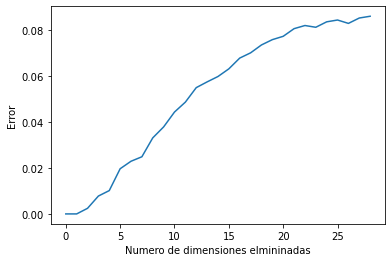

In [35]:
plt.plot(error) # El error se incrementa conforme quitamos topicos
plt.ylabel('Error');
plt.xlabel('Numero de dimensiones elmininadas');

El algoritmo SVD detrás de LSA perimite agrupar la palabras que se utilizan juntas en mismo tema. Así es como puede obtener una reducción de dimensionalida. Incluso si no planea utilizar un modelo semántico dentro de su modelo de PLN, LSA puede ser una excelente manera de comprimir la matrices de documentos para identificar posibles palabras compuestas ($n$-gramas).

### Análisis de Componentes Principales

El análisis de componentes principales es otro nombre para la SVD cuando se usa para la reducción de dimensiones, como lo hizo anteriormente para realizar su análisis semántico latente. Y el modelo PCA en scikit-learn tiene algunos ajustes en las matemáticas de SVD que mejorarán la precisión de su modelo PLN. 
Análisis de componentes principales (PCA) es una técnica estadística que se utiliza para reducir la dimensionalidad de los datos. PCA se basa en  la diagonalización de la matriz de covarianza para un conjunto de datos $X$. La matriz de covarianza $\mathit{cov}(X)$
se define como:


$$\mathit{cov} (X) = \frac {1} {n} \Sigma_{i = 1}^n x_i x_i^{T}$$

asumiendo que $E(\bar{x})= \frac {1}{n}\Sigma_{i = 1}^n x_i = 0$. El problema se puede plantear de la siguiente manera:


$$\mathit{cov} \cdot V_j = \lambda V_j$$


donde $\lambda$ son los `eigenvalores` y $V$ son los `eigenvectores`. Al resolver la ecuación anterior se genera una base ortonormal para los vectores propios $V_j$ (es decir, componentes principales. Usando $V$ se puede producir una proyección en un espacio dimensional inferior $R^{m^\prime}$ (es decir, $m^\prime<m$) con la siguiente ecuación.


$$X^\prime = X \lbrack V_1, V_2, \dots, V_{m^\prime} \rbrack$$

#### Ejemplos PCA

Antes de aplicar PCA a vectores TF-IDF revisaremos un par de ejemplos de visualización. Lo ejemplos que presentaremos fueron tomados del libro [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook)

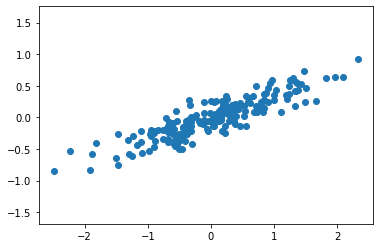

In [36]:
#Generamos un conjunto de datos en R^2 con una varianza dominante en una dirección
rng = np.random.RandomState(1)
Bp = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(Bp[:, 0], Bp[:, 1])
plt.axis('equal');

En este ejemplo claramente existe una relación lineal entre los datos, utilizando PCA determinamos los vectores  𝑉𝑗 (componentes principales ) que determinan las direcciones en las que la varianza es máxima y valores  𝜆𝑗  que nos dicen cuanta varianza se esta explicando y determinan la longitud al cuadrado de los componentes principales.

In [37]:
#Calculamos V_j y \lambda_j
pca = PCA(n_components=2)
pca.fit(Bp)

PCA(n_components=2)

In [38]:
# Para acceder los componentes principales utilizamos .components_
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [39]:
# Para acceder a los valores principales utilizamos 
print(pca.explained_variance_)

[0.7625315 0.0184779]


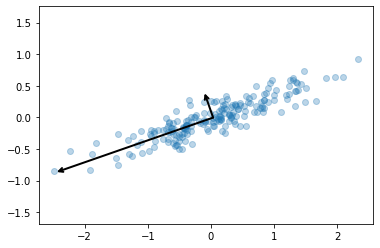

In [40]:
#Representamos los datos y los componentes principales en una misma grafica
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0,color='k')
    ax.annotate('', v1, v0, arrowprops=arrowprops)
# plot data
plt.scatter(Bp[:, 0], Bp[:, 1], alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Estos vectores representan los ejes principales de los datos, y la longitud del vector es una medida de que tan `importante` es ese eje para describir la distribución de los datos; más precisamente, es una medida de la varianza de los datos cuando se proyectan en ese eje. La proyección de cada punto de datos sobre los ejes principales son los "componentes principales" de los datos.

El uso de PCA para la reducción de dimensionalidad implica volver cero uno o más de los componentes principales más pequeños, lo que da como resultado una proyección de menor dimensión de los datos que conserva la varianza máxima en los datos.

Siguiendo con nuestro  ejemplo de PCA como una transformación de reducción de dimensionalidad:

In [41]:
pca = PCA(n_components=1)
pca.fit(Bp)
Bp_pca = pca.transform(Bp)
print("dimensión original:   ", Bp.shape)
print("dimensión reducida:", Bp_pca.shape)
print(pca.components_)

dimensión original:    (200, 2)
dimensión reducida: (200, 1)
[[-0.94446029 -0.32862557]]


Los datos transformados se han reducido a una única dimensión. Para comprender el efecto de esta reducción de dimensionalidad, podemos realizar la transformación inversa de estos datos reducidos y trazarlos junto con los datos originales:

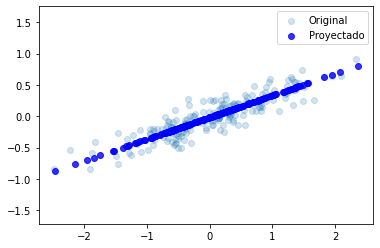

In [42]:
Bp_new = pca.inverse_transform(Bp_pca)
plt.scatter(Bp[:, 0], Bp[:, 1], alpha=0.2, label='Original')
plt.scatter(Bp_new[:, 0], Bp_new[:, 1], alpha=0.8,color='b',label='Proyectado')
plt.axis('equal');
plt.legend()

Los puntos más claros son los datos originales, mientras que los puntos oscuros son la versión proyectada. Esto hace evidente lo que significa una reducción de dimensionalidad de PCA: la información a lo largo del eje o ejes principales menos importantes se elimina, dejando solo el (los) componente (s) de los datos con la varianza más alta.
La fracción de varianza que se corta (proporcional a la extensión de puntos alrededor de la línea formada en esta figura) es aproximadamente una medida de cuánta "información" se descarta en esta reducción de dimensionalidad.

Este conjunto de datos de dimensión reducida es, en algunos sentidos, "lo suficientemente bueno" para codificar las relaciones más importantes entre los puntos: a pesar de reducir la dimensión de los datos en un 70%, la relación general entre los puntos de datos se conserva en su mayoría.

#### PCA para visualización

La utilidad de la reducción de dimensionalidad puede no ser del todo evidente en solo dos dimensiones, pero se vuelve mucho más clara cuando se observan datos de alta dimensión. Para ver esto, utilizaremos PCA para reducir la dimensionalidad  en los  datos de **dígitos** presentes en sklearn

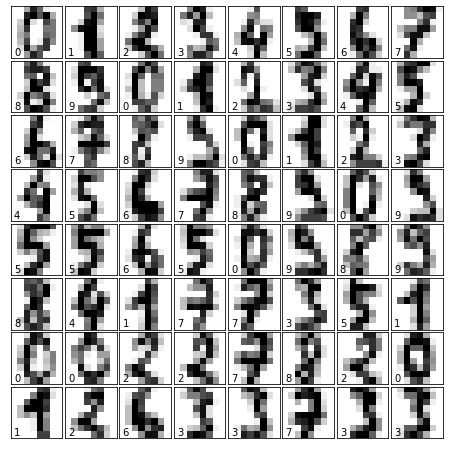

In [43]:
from sklearn.datasets import load_digits
digits = load_digits()
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Este conjuntos consta de $1797$ imágenes de dígitos escritos a mano cada una de tamaño $8\times8$ pixeles es decir cada imagen consta de $64$ pixeles y para este ejecicio representaremos cada imagen como un vector $\vec{X} \in \Bbb{R}^{64}$ estos vectores estan almacenados en **digits.data**

In [44]:
pca = PCA(n_components=2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


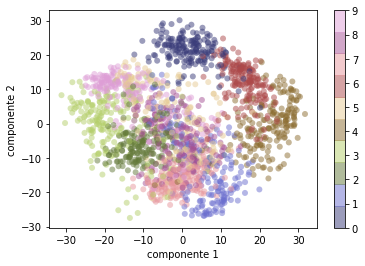

In [45]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('tab20b', 10))
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.colorbar();

#### Elegir el número de componentes
En la práctica una parte importante del uso de PCA es la capacidad de elegir cuántos componentes se necesitan para describir los datos. Esto se puede determinar observando la razón de varianza explicada acumulada en función del número de componentes:

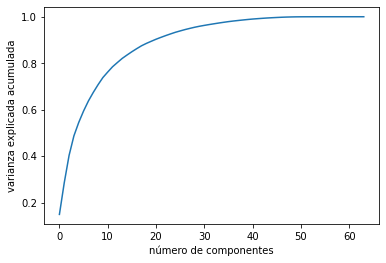

In [46]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('número de componentes')
plt.ylabel('varianza explicada acumulada');

In [47]:
np.cumsum(pca.explained_variance_ratio_)

array([0.14890594, 0.28509365, 0.40303959, 0.48713938, 0.54496353,
       0.59413263, 0.6372925 , 0.67390623, 0.70743871, 0.73822677,
       0.76195018, 0.78467714, 0.80289578, 0.82063433, 0.83530534,
       0.84940249, 0.86258838, 0.87506976, 0.88524694, 0.89430312,
       0.9031985 , 0.91116973, 0.91884467, 0.9260737 , 0.93303259,
       0.9389934 , 0.94474955, 0.94990113, 0.95479652, 0.9590854 ,
       0.96282146, 0.96635421, 0.96972105, 0.97300135, 0.97608455,
       0.97902234, 0.98158823, 0.98386565, 0.98608843, 0.98820273,
       0.99010182, 0.99168835, 0.99319995, 0.99460574, 0.99577196,
       0.99684689, 0.99781094, 0.99858557, 0.99914278, 0.99954711,
       0.99975703, 0.99983951, 0.99989203, 0.99994255, 0.99997555,
       0.99998798, 0.99999503, 0.99999804, 0.99999911, 0.99999966,
       1.        , 1.        , 1.        , 1.        ])

Esta curva cuantifica qué parte de la varianza total de las 64 dimensiones está contenida dentro de los primeros  𝑁  componentes. Por ejemplo, vemos que con estos datos, los primeros 10 componentes contienen aproximadamente el 75% de la varianza, mientras que se necesita alrededor de 50 componentes para describir cerca del 100% de la varianza.

Aquí vemos que nuestra proyección bidimensional pierde mucha información (medida por la varianza explicada) y que necesitaríamos alrededor de 20 componentes para explicar el 90% de la varianza. La gráfica resultante para un conjunto de datos de dimensiones altas puede ayudarnos a comprender el nivel de redundancia presente en múltiples observaciones.

### PCA-SVD y PLN

Ahora apliquemos  SVD sobre el ejemplo del poema, encontraremos los componentes principales que emergen del uso de  SVD. El vocabulario y la variedad de temas seran muy pequeños. Así que reduciremos  el número de temas a 5. Utilizarermos tanto la implementación de PCA como el modelo truncado de SVD para evaluar si hay diferencias.

El modelo SVD truncado está diseñado para trabajar con matrices dispersas. Lo cual lo hace ideal para trabajar con representaciones basadas en frecuencia. Tenga en mente que cuando utilice la versió de PCA de scikit-learn deberá generar las matrices densas equivalentes. 

#### PCA para análisis semántico

Probemos primero el modelo PCA de `scikit-learn`. Ya lo hemos utilizado sobre el data set de digitos; ahora vamos a utilizarlo sobre los los vectores de nuestro poema:

In [48]:
# Obtenemos cada uno de los 30 documentos en el espacio modelado por 5 tópicos
pca=PCA(n_components=5)
pca = pca.fit(W.transpose())
topicos = ['topic{}'.format(i) for i in range(pca.n_components)]
vectores_de_topicos_pca=pca.transform(W.transpose())
vtp=vectores_de_topicos_pca
pd.DataFrame(vectores_de_topicos_pca,columns=topicos)

,topic0,topic1,topic2,topic3,topic4
0,0.059643,0.289708,-0.132375,-0.063838,-0.022004
1,1.174941,-0.279268,0.336520,-0.283833,-0.302703
2,0.051288,1.043326,-0.067225,0.474478,0.060330
3,-0.090750,0.476403,-0.386288,-0.781406,0.819863
4,-0.480836,0.142581,0.994949,-0.023853,0.180451
5,-0.401226,-0.526533,-1.119535,0.344275,-0.751789
6,-0.969729,-0.660578,0.392201,0.468362,-0.108486
7,-1.054174,-0.571398,0.198101,-0.152852,0.595042
8,-0.412681,0.906320,0.852069,1.100337,0.179229
9,0.229264,0.234466,-0.520222,0.108751,-0.234550


Si queremos conocer cuales son los tópicos, podemos identificarlo con el peso de la influencia que tiene  cada palabra en cada uno de los tópicos. Cada uno de los términos del vocabulario se coresponde con cada una de las dimensiones de la matriz de tema-palabra. La podemos obtner como sigue: 

In [49]:
pesos = pd.DataFrame(pca.components_, columns=terminos, index=['topic{}'.format(i) for i in range(5)])

In [50]:
pesos # Podemos identificar que peso tiene cada palabra en cada topico

,a,agonia,algodones,arriba,arsenico,asta,ataud,ay,blanca,bordon,...,trompa,un,una,ventanas,verdes,viene,viento,y,ya,yodo
topic0,-0.382803,-0.117226,-0.075357,-0.199455,-0.199455,-0.199455,0.265576,0.362961,0.103958,-0.020889,...,0.004823,-0.054816,-0.054816,-0.054816,0.041869,0.041869,0.041869,0.124097,0.124097,0.069693
topic1,0.241675,0.064749,0.062369,0.182036,0.182036,0.182036,-0.176927,-0.136415,-0.013960,0.337290,...,0.048092,-0.056517,-0.056517,-0.056517,-0.002380,-0.002380,-0.002380,-0.119667,-0.119667,-0.029400
topic2,-0.010120,0.059406,0.031632,0.029498,0.029498,0.029498,0.069527,0.327051,0.062197,0.093335,...,-0.023892,0.034824,0.034824,0.034824,-0.027774,-0.027774,-0.027774,0.002134,0.002134,0.032120
topic3,-0.139252,-0.136253,-0.095831,-0.160602,-0.160602,-0.160602,0.002999,-0.276054,-0.086192,0.307887,...,-0.015069,0.046005,0.046005,0.046005,0.040422,0.040422,0.040422,0.064771,0.064771,-0.027312
topic4,-0.180020,-0.211639,-0.132400,-0.170934,-0.170934,-0.170934,-0.031619,-0.330757,-0.098343,0.050851,...,-0.006004,-0.011119,-0.011119,-0.011119,0.079239,0.079239,0.079239,0.038534,0.038534,-0.030661


revisemos los pesos para los terminos que más se repite en el documento `eran las cinco de la tarde`

In [51]:
pesos['eran las cinco de la tarde'.split()]

,eran,las,cinco,de,la,tarde
topic0,0.113591,-0.054816,0.003134,0.002418,-0.054816,0.000818
topic1,-0.148803,-0.056517,0.104082,0.042032,-0.056517,0.048942
topic2,-0.169738,0.034824,-0.007046,0.158245,0.034824,-0.040290
topic3,0.119774,0.046005,0.057607,-0.083810,0.046005,-0.059613
topic4,-0.090146,-0.011119,0.007871,-0.066284,-0.011119,0.035287


In [52]:
pcas=PCA(300).fit(train.toarray())

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
Xn=pcas.transform(train.toarray())
Xtp=pcas.transform(test.toarray())
clf=LDA(n_components=1)
clf.fit(Xn,y)
print(f"test f1 score:{f1(yt,clf.predict(Xtp))}, accuracy:{acc(yt,clf.predict(Xtp))}")
print(f"train f1 score:{f1(y,clf.predict(Xn))}, accuracy:{acc(y,clf.predict(Xn))}")

test f1 score:0.4299065420560748, accuracy:0.9277251184834123
train f1 score:0.5403111739745403, accuracy:0.9432116023064826


podemos ver que los tópico 1 es el unico positivo a `eran`mientras que todos los demás tiene un peso negativo. 

#### SVD truncado para análisis semántico

Ahora aplicaremos TruncateSVD implementado en `scikit-learn`. Este es un enfoque más directo de LSA que pasa por alto el modelo scikit-learn PCA para que pueda ver lo que está sucediendo dentro del contenedor PCA. Puede manejar matrices dispersas, por lo que si se está trabajando con grandes conjuntos de datos, debería preferir el uso de SVD sobre PCA. Midiante el uso de  TruncatedSVD se divide la matriz TF-IDF en las 3 matrices $U$, $S$ y $Vt$ y posteriormente descartarás las dimensiones que contienen menos información. Las dimensiones desechadas representan los tópicos que presentan la menor varianza en el corpus. Ahora utilizaremos TruncateSVD para retener los 5 tópicos más relevantes.

In [54]:
from sklearn.decomposition import TruncatedSVD

In [55]:
svd = TruncatedSVD(n_components=5, n_iter=100)
vectores_de_topicos_svd = svd.fit_transform(W.transpose())
pd.DataFrame(vectores_de_topicos_svd ,columns=topicos)

,topic0,topic1,topic2,topic3,topic4
0,2.355420,0.177075,0.280541,-0.021987,0.051541
1,2.135422,1.267206,-0.641460,-0.138354,-0.051457
2,2.454846,0.294671,0.949062,0.480004,-0.291394
3,2.471366,0.079994,0.558910,-0.178614,1.103789
4,2.595810,-0.287759,-0.320749,0.987064,0.239092
5,2.615581,-0.362157,0.076434,-1.248797,-0.839765
6,2.675360,-0.959054,-0.621263,0.213066,-0.442012
7,2.720107,-1.023609,-0.458393,0.061369,0.447676
8,2.594131,-0.171800,0.513578,1.405529,-0.680953
9,2.445984,0.385983,0.375545,-0.439329,-0.287808


In [56]:
svd = TruncatedSVD(n_components=300, n_iter=100)
svd.fit(train)
Xn=svd.transform(train)
Xtp=svd.transform(test)
clf=LDA(n_components=1)
clf.fit(Xn,y)
print(f"test f1 score:{f1(yt,clf.predict(Xtp))}, accuracy:{acc(yt,clf.predict(Xtp))}")
print(f"train f1 score:{f1(y,clf.predict(Xn))}, accuracy:{acc(y,clf.predict(Xn))}")

test f1 score:0.4150943396226416, accuracy:0.9265402843601895
train f1 score:0.5372714486638537, accuracy:0.942512668181024


### Utilizando SVD truncado para análisis semántico

Ahora apliquemos SVD truncado al problema de clasificación de tweets ofensivos. Para este ejemplo truncaremos a 64 tópicos. 

In [57]:
tindex=[f"tweet{i}{label}" for i,label in enumerate(train_df.offensive)]
svdt = TruncatedSVD(n_components=64, n_iter=100)
vectores_de_topicos = svdt.fit_transform(train)
vectores_de_topicos=pd.DataFrame(vectores_de_topicos, columns=['topico{}'.format(i) for i in range(64)],
            index=tindex)

In [58]:
vectores_de_topicos.head().round(2)

,topico0,topico1,topico2,topico3,topico4,topico5,topico6,topico7,topico8,topico9,...,topico54,topico55,topico56,topico57,topico58,topico59,topico60,topico61,topico62,topico63
tweet0NO,0.11,-0.03,-0.00,0.01,0.06,-0.02,-0.01,-0.01,0.03,-0.05,...,0.05,0.04,0.03,-0.02,-0.02,0.03,0.01,-0.02,0.00,0.01
tweet1NO,0.09,-0.01,-0.01,0.01,-0.01,-0.00,-0.02,0.08,-0.04,-0.05,...,-0.02,0.04,0.00,0.01,-0.01,0.02,-0.02,-0.01,-0.02,-0.03
tweet2NO,0.13,-0.06,-0.03,-0.08,0.01,-0.07,-0.09,-0.04,-0.03,0.02,...,-0.05,0.02,0.00,0.06,-0.04,0.00,0.08,-0.04,-0.01,-0.00
tweet3NO,0.06,-0.02,-0.02,-0.04,-0.01,-0.02,-0.04,-0.02,-0.01,0.00,...,0.01,-0.06,0.02,0.00,-0.00,-0.05,-0.01,-0.06,-0.03,0.02
tweet4OFF,0.05,-0.02,-0.00,0.00,-0.00,0.01,0.02,-0.02,0.00,0.02,...,-0.02,0.00,0.01,-0.01,-0.00,0.00,0.01,-0.01,0.00,0.03


Una vez que obtenemos los tópicos podemos tener una idea de que tan bien funcionara el modelo semántico para clasificación revisando que tan correlacionado está la similitu coseno con la pertenencia a la misma clase.

In [59]:
vectores_de_topicos_norm=(vectores_de_topicos.T / np.linalg.norm(vectores_de_topicos, axis=1)).T

In [60]:
vectores_de_topicos_norm.iloc[[0,1,3,4,15,20,40]].dot(vectores_de_topicos_norm.iloc[[0,1,3,4,15,20,40]].T).round(1)

,tweet0NO,tweet1NO,tweet3NO,tweet4OFF,tweet15OFF,tweet20OFF,tweet40OFF
tweet0NO,1.0,0.2,0.1,0.0,0.1,-0.1,-0.0
tweet1NO,0.2,1.0,0.0,-0.1,0.1,-0.0,0.0
tweet3NO,0.1,0.0,1.0,0.1,0.2,0.1,-0.0
tweet4OFF,0.0,-0.1,0.1,1.0,0.1,0.0,0.1
tweet15OFF,0.1,0.1,0.2,0.1,1.0,0.2,0.0
tweet20OFF,-0.1,-0.0,0.1,0.0,0.2,1.0,0.0
tweet40OFF,-0.0,0.0,-0.0,0.1,0.0,0.0,1.0


De la pequeña muestra podríamos tener un poco de evidencia que la similitud tienen a ser mayor entre tweets de la misms clases. La  búsqueda semántica puede usar la similitud de coseno entre un vector de consulta y todos los vectores de tema en la base de datos de documentos para encontrar el más similar semánticamente. Desafortunadamente, esta similitud entre los vectores de temas dentro de cada clase, muy probablmente  no se mantenga para todos los tweets. Por lo que definir una frontera lineal entre ambas clases sería difícil para este conjunto de vectores temáticos. Resulta difícil establecer un umbral en la similitud que asegure que siempre se puedan clasificar correctamente los tweets. Pero, en general, si el espcacio semántico es representativo cuanto más contenido ofensivo tenga un tweet, menos similar será de otro que no lo sea. Si se cumple lo anterior podríamos crear un sistema que discrimime correctamente las clases implicadas. 

Cuando utilicemos SVD truncado es buena idea normalizar los vectores de frecuencia (dividiendolos por su norma) y centrarlos substrayendo la frecuencia media de cada término.

### Alternativas a LSA/SVD

El éxito de la descomposición de valores singulares para el análisis semántico y la reducción de dimensiones ha motivado el desarrollo de algorimtos mejorados. Aun cuando las mejoras estan enfocadas en problemas que no son  PLN, nada impidide que puedan utilizarse con ese próposito. Por lo tanto, puedes resultar de utilidad para el análisis semántico. Algunos de lo métodos reportados son:

- **Quadratic discriminant analysis (QDA)**. A diferencia de LDA, QDA realiza una transformación cuadrática. Esta transformación define un espacio vectorial que puede ser utilizado para discriminar entre diferentes clases. 
- **Proyección aleatoria**. Es una técnica de descomposición/transformación  similar a SVD, pero el algoritmo es estocástico, por lo que diferentes ejecuaciones obtienen diferente respuesta. Su naturaleza estocástica facilita su implementación en paralelo. Y en algunos casos (para algunas de esas ejecuciones aleatorias), puede obtener transformaciones que son mejores que las obtenidas mediante de SVD. 
- **Factorización matricial no negativa (NMF)**. Es una familia de algoritmos para la factorización de matrices. NMF tiene la particularidad de que los factores obtenidos no tienen elementos negativos. Esta no negatividad hace que las matrices resultantes sean más fáciles de inspeccionar. 

## Latent Dirichlet allocation (LDiA)

Aún cuando LSA debería ser la primera opción para la mayoría de modelos de tópicos, búsqueda semántica o motores de recomendaciones basados en contenido. LDiA puede dar resultados mejores en algunas situaciones.
LDiA es similar a LSA, pero a diferencia de LSA, LDiA asume que las frecuencias de terminos tienen una distribución de Dirichlet.

LDiA crea un modelo de espacio vectorial semántico utilizando un enfoque mas similar a como lo haría una persona utilizando su intuición. La combinación de temas de un documento se determina mediante la combinación de palabras en cada tópico según el tema al que se asignaron esas palabras. Lo anterior hace que un modelo LDiA sea mucho más fácil de interpretar, porque las palabras asignadas a los temas y los temas asignados a los documentos tienden a tener más sentido que para los modelos LSA. 

LDiA asume que cada documento es una combinación lineal de un número arbitrario de temas los cuales se seleccionan para entrenar el modelo LDiA. LDiA también asume que cada tema puede ser representado por una distribución de palabras (frecuencias de tokens). Se parte de la idea de que la probabilidad o el peso de cada uno los temas sea parte de un documento, así como de la probabilidad de que una palabra sea asignada a un tema están definidad por una distribución de probabilidad de Dirichlet.

### LDiA para modelado de tópicos

Como ya hemos mencionado los temas determinado utilizando LDiA tienden a ser más comprensibles para los humanos. Esto se debe a que a las palabras que aparecen juntas con frecuencia se les asignan a los mismos temas, tal y como lo esperariamos. Por otro lado, LSA intenta mantener la separación(varianza) entre los datos, mientras que LDiA intenta mantener unidos los términos que están unidos en el corpus. Las dos estrategias optimizan cosas diferentes  Para mantener juntos los vectores de alta dimensión en el espacio de dimensión inferior, LDiA tiene deformar  el espacio (y los vectores) de formas no lineales.

Ahora apliquemos LDiA al conjunto de datos de EmoEval, etiquetados como ofensivos y no ofensivos. Primero calcularemos los vectores de frecuencia y luego algunos vectores de temas para cada tweet en el corpus. Asumimos el uso 16 topicos. Mantener un número bajo de temas (dimensiones) puede ayudar a reducir el sobre-aprendizaje. 
Dado que LDiA utiliza vectores  BoW sin procesar en lugar de vectores TF-IDF normalizados. Calcularemos los vectores BOW usando scikit-learn. 


In [61]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import casual_tokenize
from utilidades import my_tokenizer
np.random.seed(3)
counter = CountVectorizer(tokenizer=my_tokenizer)

In [62]:
vsm=counter.fit_transform(raw_documents=train_df.tweet)
cols_num,terms_bow=zip(*sorted(zip(counter.vocabulary_.values(), counter.vocabulary_.keys())))
tweets_bows=pd.DataFrame(vsm.toarray(),index=tindex, columns=terms_bow)

In [63]:
tweets_bows.head()

,!,...,0,00,01,02,03,04125395473,08mar19,08x03,...,zonas,zoom,zozobra,zp,zulia,zuliano,zurda,zurdos,zweig,zzz
tweet0NO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tweet1NO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tweet2NO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tweet3NO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tweet4OFF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Revisamos los diferentes de 0
tweets_bows.loc['tweet0NO'][tweets_bows.loc['tweet0NO']>0]

cuantas          1
dejado           1
dudas            1
gran             1
guerra           1
juegodetronos    1
momentos         1
recuerdo         1
unas             1
Name: tweet0NO, dtype: int64

Ahora utilicemos LDiA sobre el corpus de entrenamiento

In [65]:
from sklearn.decomposition import LatentDirichletAllocation as LDiA
np.random.seed(3)
ldia = LDiA(n_components=8).fit(tweets_bows)

In [66]:
# verificamos  la dimension
ldia.components_.shape

(8, 14377)

El modelo resultante asigno  18953 tokens en 16 tópicos (componentes). Ahora revisaremos algunas palabras y cómo se asignan los pesos en cada uno de los 16 temas. Dado que LDiA es un algoritmo estocástico diferentes corridas obtendrán diferentes resultados. Por lo tanto, los pesos de las palabras y los temas serán diferente en cada ejecución, pero deberían tener magnitudes similares. Para prevenir resultados diferentes podemos establecer una la semilla en un valor fijo. 

In [67]:
componentes = pd.DataFrame(ldia.components_.T, index=terms_bow, columns=['topico{}'.format(i) for i in range(8)])

In [68]:
componentes.head().round(2)

,topico0,topico1,topico2,topico3,topico4,topico5,topico6,topico7
!,0.13,2.12,0.13,19.82,0.13,0.13,0.13,6.43
...,4.77,4.98,5.50,4.33,29.38,17.10,6.82,0.13
0,0.13,0.13,3.24,0.13,1.12,0.13,29.01,0.13
00,0.13,0.13,0.13,0.13,0.13,0.13,28.12,0.13
01,0.13,0.13,0.13,0.13,0.13,0.13,4.12,0.13


El signo de excalmación (!) esta presente en todos los tópicos, además tiene un peso fuerte en la mayoria de los temas, mientras que ne lo tópicos 3,5 10 y 14. Note que en el tema 13  el signo de exclamación tiene un peso mucho menor que el simbolo de ("), lo cual podría implicar que el tópico 13 es más acerca del número de citas que de la intensidad con que se expresa el sentimiento.

In [69]:
componentes.topico5.sort_values(ascending=False)[:10]

venezuela                  548.245390
user                       312.230379
elecccionesgenerales28a    159.710269
maduro                     108.919214
pais                        81.224885
golpe                       62.130784
pueblo                      59.871610
espana                      54.422933
venezuelalibre              51.311640
30abr                       46.163516
Name: topico5, dtype: float64

Podemos ver que lo 15 tokens principales para el tema 13 son palabras relacionada con libros, los cuales están relacionados con citas. Sería interesante saber si este se utiliza mas o menos mensajes ofensivos, o en algunas de las emociones. Puede ver que la asignación de palabras a los temas se puede racionalizar o razonar, incluso un vistazo rápido a los terminos.
Ahora vamos a porbar como utilizar estos vectores para la tarea de clasificación utilizando LDA. Para utilizar LDA primero debemos transformar todos los documentos tweets al espacio semántico.

In [70]:
train_ldia16 = ldia.transform(tweets_bows)
test_tweets_bows=counter.transform(test_df.tweet)
test_ldia16=ldia.transform(test_tweets_bows)

In [71]:
train_ldia16.shape

(5723, 8)

In [72]:
pd.DataFrame(train_ldia16,index=tindex) # cada tweet en el espacio semantico de 16 temas

,0,1,2,3,4,5,6,7
tweet0NO,0.269774,0.012522,0.538086,0.129559,0.012519,0.012523,0.012513,0.012505
tweet1NO,0.013900,0.013893,0.013889,0.690898,0.013892,0.225718,0.013903,0.013908
tweet2NO,0.020833,0.020836,0.679332,0.020836,0.195610,0.020836,0.020869,0.020848
tweet3NO,0.010424,0.010433,0.247793,0.010424,0.010427,0.689653,0.010424,0.010422
tweet4OFF,0.225022,0.624769,0.025000,0.025036,0.025031,0.025087,0.025007,0.025047
...,...,...,...,...,...,...,...,...
tweet5718NO,0.005960,0.005962,0.005971,0.719902,0.005960,0.244324,0.005958,0.005964
tweet5719NO,0.140609,0.015626,0.629589,0.015625,0.015627,0.015628,0.015628,0.151667
tweet5720NO,0.010432,0.010417,0.010422,0.010426,0.010423,0.783347,0.154113,0.010421
tweet5721NO,0.007356,0.007355,0.007368,0.007362,0.007356,0.007357,0.007357,0.948490


Ya vimos que los temas obtenidos por LDiA son interpretables por los humanos, pero ¿qué pasa con las algoritmos de aprendizaje? ¿Qué resultados obtendrá un clsificador LDA en este espacio? 

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [74]:
ldac = LDA(n_components=1)
ldac.fit(train_ldia16,y)
yp=ldac.predict(test_ldia16)
ypt=ldac.predict(train_ldia16)
print(f"test f1 score:{f1(yt,yp)}, accuracy:{acc(yt,yp)}")
print(f"train f1 score:{f1(y,ypt)}, accuracy:{acc(y,ypt)}")

test f1 score:0.0, accuracy:0.909952606635071
train f1 score:0.0, accuracy:0.9178752402586057


El performance no es mejor que con el clasificador Naïve Bayes, y es peor que utilizando LDA sobre los vectores TF-IDF, esto es debido a que LDiA es bueno para encontrar temas explicables, que pueden ser utilies para generar resumenes pero no necesariamente para separar clases. Mientras que los otros enfoques trantan de maximixar la separación los vectores de temas, lo que permite una brecha más amplia entre los documentos lo cual, por lo general tendrá mejores resultados para separar las clases mediante el uso de un hiperplano. Aún así encrementando el número tópicos podría obtnerse una mejora. Pruebe por ejemplo utilizar 300 (es un número estándar para word embeddings).

## Distancia y similitud
En el espacio semántico también podemos utilizar las funciones de similitud/distancia. Recuerdemos que la similitud (y distancias) nos permite deteminar que tan similares o distantes están dos documentos en función de la similitud (o distancia) de los vectores que los representan.

Podemos utilizar la similitud/distancias para determinar qué tan bienLSA concuerda con el modelo TF-IDF de mayor dimensión. Deseariamos que los documentos que significan cosas similares están cerca unos de otros en su nuevo espacio vectorial de temas.

Usualmente, LSA preserva la distancias grandes, pero no siempre conserva las distancias cercanas. Esto es resultado de que SVD se centra en maximizar la variación entre todos sus documentos en el nuevo espacio vectorial de temas.
Distancias representativas entre los vectores de características (vectores de palabras, vectores de temas, vectores de contexto de documentos, etc.) contribuyen a mejorar el rendimiento de los sistemas de PLN o de cualquier modelo de aprendizaje automático. A continuaión listamos ejemplos de  funciones de distancia:

- Distancia euclidiana, error cuadrático medio (RMSE): $L_2$
- Distancia eculidiana al cuadrado, suma de distancias al cuadrado (SSD): $L_2^2$ 
- Ditancia coseno o ángulo (producto normalizado)
- Distancia Minkowki: $L_p$
- Distancia fracionaria, $L_p$ para $0<p<1$
- Distancia Manhattan: $L_1$
- Distancia Jaccard
- Distancia Mahalanobis
- Distancia de Levenshtein o de edición

La amplia variedad de formas de calcular la distancia es evidencia de lo imporate que es conocer las relaciones en entre los objetos de un conjunto. Además de las implementaciones de distancia por pares en `Scikit-learn`, muchas otras se utilizan en especialidades matemáticas como topología, estadística e ingeniería. A continuación mostramos la lista de distancias que puede encontrar en el modulo `sklearn.metrics.pairwise` y `scipy.spatial.distance`. 

In [75]:
from sklearn.metrics import pairwise
pairwise.PAIRWISE_DISTANCE_FUNCTIONS.keys() # Soportan matrices dispersas

dict_keys(['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean'])

In [76]:
# scipy no trabajan en matrices dispersas
['braycurtis','canberra','chebyshev','cityblock','correlation','cosine','dice','directed_hausdorff',
 'euclidean','hamming','jaccard','jensenshannon','kulsinski','mahalanobis','matching','minkowski',
 'rogerstanimoto','russellrao','seuclidean','sokalmichener','sokalsneath','sqeuclidean','wminkowski','yule'];

Las medidas de similitud a menudo se calculan a partir de medidas de distancia y viceversa, de modo que las distancias son inversamente proporcionales a las funciones de similitud. Usualmente las funciones de similitud son diseñadas para tomar valores entre 0 y 1. Algunas formas comunes para calcular distancias a partir de similutdes y viceversa son:

$$\mathit{similitud}=1 / (1+\mathit{distancia})$$
$$\mathit{distancia}=1/\mathit{similitud}-1$$

Sin embargo en  funciones que oscilan entre 0 y 1, como probabilidades, escomún usar una fórmula como la siguiente:

$$\mathit{similitud}=1 - \mathit{distancia}$$
$$\mathit{distancia}=1 - \mathit{similitud}$$

Las distancias de coseno tienen su propia convención para el rango de valores que utilizan. La distancia angular entre dos vectores a menudo se calcula como una fracción de la separación angular máxima posible entre dos vectores, que es 180 grados o $\pi$ en radianes. Como resultado, la similitud del coseno y la distancia son recíprocas entre sí.

Los términos `distancia` y `longitud` a menudo se confunden con el término `métrica`, porque muchas distancias y longitudes son métricas válidas. Pero, lamentablemente, no todas las funciones de distancia pueden llamarse métricas. Aún más confuso, las métricas a veces también se denominan "funciones de distancia" o "métricas de distancia" en matemáticas formales y textos de teoría de conjuntos.

En matemáticas, una  métrica o función de distancia es una función que define un valor de distancia entre un par de elementos/objetos definidos en un espacio métrico. La métrica induce una topología en espacio, en visualización nos interesa utilizar la topología inducida para ganar entendimiento delos datos bajo análisis. 

Toda métrica $d$ satisfase  los siguientes tres axiomas:

- $d(X,Y)=0$ si y solo si $X=Y$
- $d(X,Y)=d(X,Y)$ simetria
- $d(X,Y)\leq d(X,Z) + d(X,Z)$ desigualdad del triángulo

## LSA dirigido por la distancia

Hasta hora se ha utilizado LSA sin considerar la información sobre la similitud entre documentos. Es decir, lo hemos utilizado como un proceso de aprendizaje no supervisado para la extracción de características (temas), en el que no importa que tan similares son los vectores de tema entre sí. No se tiene en cuenta cómo se los vectores entre sí.

El uso de métricas es parate del estado del arte pata los procesos de reducción de dimensión y extracción de características. Esto dado que al usar la distancia en conjunto con el algoritmo de aprendizaje, se puede `guiar/dirigir` los vectores para que minimicen alguna función de costo. De esta manera, es posible optimizar los vectores para "centrarlos" en algún aspecto del contenido de la información bajo estudio.
En las secciones anteriores sobre LSA, se ignoró toda la metainformación sobre sus documentos. Por ejemplo, con los tweets ignoramos el campo `event`, el cual sin duda es un buen indicador de la similitud entre los temas y por tanto podría usarse para informar su transformación de vector de tema (LSA).

Entrenemos un modelo de análisis discriminante lineal utilizando los tweets etiquetados. Recuerde que LDA funciona de manera similar a LSA, excepto que requerimos  las etiquetas de clasificación u otro score para poder encontrar la mejor combinación lineal de las dimensiones en un espacio de alta dimensión (los términos en un vector BOW o TF-IDF). En lugar de maximizar la separación (varianza) entre todos los vectores en el nuevo espacio, LDA maximiza la distancia entre los centroides de los vectores dentro de cada clase.
 A LDA debemos los "temas" a modelar, esto los hacemos mediante losejemplos (vectores etiquetados). Sólo entonces el algoritmo puede calcular la transformación óptima de su espacio de alta dimensión al espacio de dimensión inferior. Sin embargo, el vector de menor dimensión resultante no puede tener más dimensiones que la cantidad de etiquetas de clase  proporcionados. Debido a que solo tiene un tema de "OFFENSIVIDAD" para entrenar, veamos qué tan preciso puede ser su modelo de unidimensional tema 1D para clasificar los tweets:

In [84]:
ldad = LDA(n_components=1)
ldad = ldac.fit(train.toarray(), y)

In [85]:
yp=ldad.predict(test.toarray())
ypt=ldad.predict(train.toarray())
print(f"test f1 score:{f1(yt,yp)}, accuracy:{acc(yt,yp)}")
print(f"train f1 score:{f1(y,ypt)}, accuracy:{acc(y,ypt)}")

test f1 score:0.2743362831858407, accuracy:0.8056872037914692
train f1 score:0.9925611052072264, accuracy:0.9987768652804473


Podemos observar que hay un sobre aprendizaje, lo cual era de esperar dados lod 18489 términos en los vectores TF-IDF, por lo que no es de extrañar que LDA se haya memorizado la respuesta. Por ello el desempeño sobre el conjunto de entrenamiento es mucho mejor que en el conjuto de prueba.

Entonces, con LSA, puede caracterizar un mensaje tweet con solo 16 dimensiones y aún tener mucha información para clasificarlos como Ofensivo o no ofensivo. Y es mucho menos probable que su modelo de dimensiones reducidas se sobreajuste. Esto ya lo mostramos cuando utilizamos los vectores obtenido por LSA en como entrada para LDA, el cuál implicitamente optimza los topicos centrales. Retomamos el perfomance obtenino donde podemos observar que LDA generaliza mejor utilizando LSA.

In [89]:
print(f"test f1 score:{f1(yt,clf.predict(Xtp))}, accuracy:{acc(yt,clf.predict(Xtp))}")
print(f"train f1 score:{f1(y,clf.predict(Xn))}, accuracy:{acc(y,clf.predict(Xn))}")

test f1 score:0.4150943396226416, accuracy:0.9265402843601895
train f1 score:0.5372714486638537, accuracy:0.942512668181024


## Búsqueda semántica

Con los vectores de tema, es posible comparar el significado de palabras, documentos, sentencia  o incluso  corpus. Es decir, en el espacio semántico podemos encontrar "grupos" de documentos y frases similares. Las comparaciónes realizadas en una representación semántica ya no se limitan solamente a palabras clave y la clasificación de relevancia basada completamente en la elección de palabras o el vocabulario. Ahora es posible encontrar documentos que son relevantes para su consulta, no solo una buena coincidencia para las estadísticas de palabras en sí mismas.

Lo anterior hace posible la "búsqueda semántica". Esta estrategia es la que los motores de búsqueda sólidos cuando le brindan documentos que no contienen muchas de las palabras de su consulta, pero que son exactamente lo que que estabas buscando. Estos motores de búsqueda avanzados utilizan vectores de temas LSA para diferenciar, por ejemplo entre el lenguage de programación Python  y una serpiente "Python.

La búsqueda semántica es  una herramienta que permite encontrar y generar texto significativo. Sin mebrago, no neceariamente son fáciles de interpretat por humanos, lo anterior debido a la alta dimensión de los vectores (usualemente limitados a 2 o 3 dimensiones).  Si leimos Flatland de Abbott, recordará que se utilizan muchas visualizaciones 2D para ayudar al protagonista a explorar las sombras de los objetos 3D, de igual forma las proyecciones realizadas de las matrices dispersas son la sombras de las palabras que las generaron. 

## Referencias
[1] Lane, H., Howard, C., & Hapke, H. (2019). Natural Language Processing in Action Video Edition. Manning Publications.
[2] Borg, I., & Groenen, P. J. (2005). Modern multidimensional scaling: Theory and applications. Springer Science & Business Media. <br>
[3] Schölkopf, B., Smola, A., & Müller, K. R. (1997, October). Kernel principal component analysis. In International conference on artificial neural networks (pp. 583-588). Springer, Berlin, Heidelberg.<br>
[4] Talwalkar, A., Kumar, S., Morhri, M., & Rowley, H. A. (2013). Large Scale SVD and Manifold Learning.